# Binary Quadratic Model (BQM)
class of problems consist of Ising model and Quadratic Unconstrained Binary Optimization (QUBO)

<!-- ams math -->
$
\begin{align}
 min \bigg( \sum_i a_i v_i + \sum_i \sum_{j>i} b_{i,j} v_i v_j + c \bigg)
\end{align}
$

### Problems to BQM

From a simple 2 vars problem, say $v_1$ and $v_2$. We want a BQM that represents the constraint $v_1 = v_2$.\
For **QUBO** and **Ising** we follow the same process. 

1) ***Make constraint satisfaction table***\
set up a table for 2 variables that covers all possible values they might take.\
Since the goal is to minimize, if a column satisfies the constraint, assign the value to be 0.

\begin{array}{|c|c|c|c|c|}
\hline
\text{QUBO} & & \text{Ising} & & \\
\hline
x_1 & x_2 & s_1 & s_2 & = \\
\hline
0 & 0 & -1 & -1 & 0 \\
0 & 1 & -1 & +1 & 1 \\
1 & 0 & +1 & -1 & 1 \\
1 & 1 & +1 & +1 & 0 \\
\hline
\end{array}


2) ***Make a system of equations***


\begin{array}{| c |}
\hline
\text{QUBO} \\
\hline
a_1 * 0 + a_2 * 0 + b_{1, 2} * 0 * 0 + c = 0\\
\hline
a_1 * 0 + a_2 * 1 + b_{1, 2} * 0 * 1 + c = 1\\
\hline
a_1 * 1 + a_2 * 0 + b_{1, 2} * 1 * 0 + c = 1\\
\hline
a_1 * 1 + a_2 * 1 + b_{1, 2} * 1 * 1 + c = 0\\
\hline
\end{array}

\begin{array}{| c |}
\hline
\text{Ising} \\
\hline
h_1 * 0 + h_2 * 0 + J_{1, 2} * 0 * 0 + c = 0\\
\hline
h_1 * 0 + h_2 * 1 + J_{1, 2} * 0 * 1 + c = 1\\
\hline
h_1 * 1 + h_2 * 0 + J_{1, 2} * 1 * 0 + c = 1\\
\hline
h_1 * 1 + h_2 * 1 + J_{1, 2} * 1 * 1 + c = 0\\
\hline
\end{array}


3) ***Solve tge system of equations***

\begin{array}{| c | c |}
\hline
\text{QUBO} & \text{Ising} \\
\hline
a_1 = 1 & h_1 = 0\\
\hline
a_2 = 1 & h_2 = 0\\
\hline 
b_{1, 2} = -2 & J_{1, 2} = -0.5\\
\hline
c = 0 & c = 0.5\\
\hline
\end{array}


# TBA

### Ex: Choosing Boxes
We're given three boxes with different weights. We want to choose the two boxes with the smallest sum.

\begin{array}{| c | c | c | c |}
\hline
& \text{Box 1} & \text{Box2} & \text{Box3} \\
\hline
Weight & 15 & 20 & 25\\
\hline
\end{array}



In [261]:
from itertools import product
import numpy as np



def make_binomial_coef(coefs, gamma=1) -> list[np.ndarray, np.ndarray, int]:
    """
    Given a list of coefficients, return the coefficients of the binomial expansion of the square of the sum of the coefficients.
    [x1, x2, x3 ... c]"""
    n = 2
    num_terms = len(coefs)

    # Initialize two arrays: one for the products (2D), and one for linear terms (1D)
    products_2d = np.full((num_terms - 1, num_terms - 1), gamma)
    linear_1d = np.full(num_terms - 1, gamma)
    constant = gamma

    # Iterate through all combinations of exponents that sum to 2 (for x1, x2, x3, and the constant)
    for exponents in product(range(n + 1), repeat=num_terms):
        if sum(exponents) == n:
            idxs = [i for i, e in enumerate(exponents) if e > 0]
            if num_terms - 1 in idxs:
                if len(idxs) == 1:
                    constant = coefs[num_terms - 1] ** 2
                else:
                    linear_1d[idxs[0]] *= 2 * coefs[idxs[0]] * coefs[idxs[1]]
            else:
                if len(idxs) != 1:
                    products_2d[idxs[1], idxs[0]] *= coefs[idxs[0]] * coefs[idxs[1]]
                products_2d[idxs[0], idxs[-1]] *= coefs[idxs[0]] * coefs[idxs[-1]]
    
    return products_2d, linear_1d, constant
            
   

In [279]:
from qiskit_optimization import QuadraticProgram

# Create an empty QuadraticProgram
qp = QuadraticProgram("Choosing Boxes")

# weights 
weights = np.diag([15, 20, 25])

# recall BQM = min( objective + penalty * constraint^2)
objective_linear = np.zeros(3) # C


for i in range(3):
    qp.binary_var(f"x{i + 1}")
    objective_linear[i] = weights[i, i]

# penalty
gamma = 25
quad, lin, constant = make_binomial_coef([1, 1, 1, -2], gamma)

# maximize the objective so we need to negate the objective
qp.minimize(linear=lin - objective_linear, quadratic=quad, constant=constant)


print(qp.prettyprint())

Problem name: Choosing Boxes

Minimize
  25*x1^2 + 50*x1*x2 + 50*x1*x3 + 25*x2^2 + 50*x2*x3 + 25*x3^2 - 115*x1 - 120*x2
  - 125*x3 + 4

Subject to
  No constraints

  Binary variables (3)
    x1 x2 x3



In [280]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

qubitOp, offset = qp.to_ising()  
print(qubitOp, offset)

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[20. +0.j, 22.5+0.j, 25. +0.j, 12.5+0.j, 12.5+0.j, 12.5+0.j]) -101.0


In [281]:
# exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
# result = exact.solve(qp)
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(qubitOp)
# print(result.prettyprint())
print("energy:", result.eigenvalue.real)
print("objective:", result.eigenvalue.real + offset)
print("solution")
display(result.eigenstate.draw(output='latex'))

energy: -40.0
objective: -141.0
solution


<IPython.core.display.Latex object>

### Ex. 2
A business is trying to figure out the best way to pack a box full of items. there are five item, with values 1, 5 ,3,  4 and 2 dollars. These items have weights 2, 4, 4, 1, and 3 lbs, respectively. The contents of the box must weight exactly 6 lbs. What is the best way to pack the box so that the nox has the highest total value?

In [356]:
qp_2 = QuadraticProgram("Walmart Knapsack")

# objective maxmimize the profit
obj = np.array([1, 5, 3, 4, 2])

# constraints
quad, lin, const = make_binomial_coef([2, 4, 4, 1, 3, -6], 5)

qp_2.binary_var_list(range(1, 6), "x")

qp_2.maximize(linear=lin - obj, quadratic=quad, constant=const)
print(qp_2.prettyprint())

qubitOp, offset = qp_2.to_ising()


solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(qubitOp)
# print(result.prettyprint())
print("energy:", result.eigenvalue.real)
print("objective:", result.eigenvalue.real + offset)
print("solution")
display(result.eigenstate.draw(output='latex'))
 


Problem name: Walmart Knapsack

Maximize
  20*x1^2 + 80*x1*x2 + 80*x1*x3 + 20*x1*x4 + 60*x1*x5 + 80*x2^2 + 160*x2*x3
  + 40*x2*x4 + 120*x2*x5 + 80*x3^2 + 40*x3*x4 + 120*x3*x5 + 5*x4^2 + 30*x4*x5
  + 45*x5^2 - 121*x1 - 245*x2 - 243*x3 - 64*x4 - 182*x5 + 36

Subject to
  No constraints

  Binary variables (5)
    x1 x2 x3 x4 x5

energy: -250.0
objective: -161.0
solution


<IPython.core.display.Latex object>

In [178]:


def walmart_minimum_solver(quad, lin, const):
    """bruteforce solver"""
    minimum = float("inf")
    state = None

    for i in range(2**5):
        c = const
        c += sum([coef * int(j)  for j, coef in zip(f"{i:05b}", lin)])
        for x_i, row in enumerate(quad):
            for x_j, coef in enumerate(row):
                c += coef * int(f"{i:05b}"[x_i]) * int(f"{i:05b}"[x_j])
        # print(c, f"{i:05b}")
        if c < minimum:
            minimum = c
            state = f"{i:05b}"

    return minimum, state

# print(quad, lin, const)
print(walmart_minimum_solver(quad, lin - obj, const))

(-331, '10011')


### VQE

In [290]:
from qiskit.circuit.library import EfficientSU2
from scipy.optimize import minimize

from qiskit_aer.primitives.estimator_v2 import EstimatorV2
from qiskit_aer import AerSimulator

In [291]:
Hamiltonian = qubitOp


Hamiltonian.to_operator().draw(output='latex')

<IPython.core.display.Latex object>

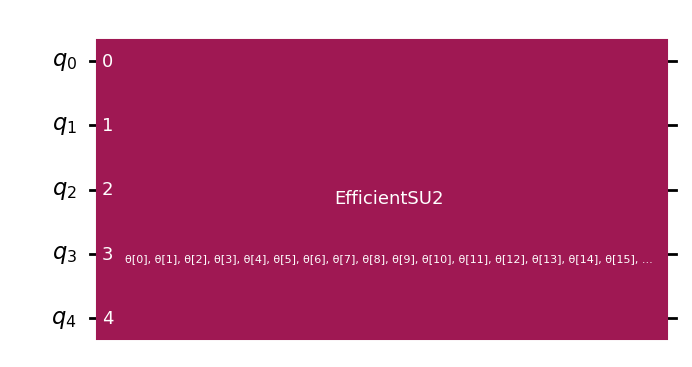

In [292]:
ansatz = EfficientSU2(Hamiltonian.num_qubits)
display(ansatz.draw(output='mpl'))

num_params = ansatz.num_parameters

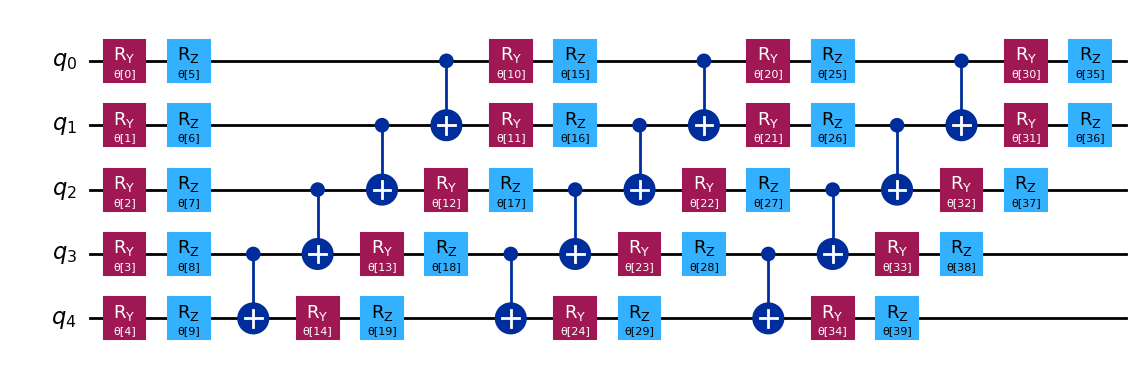

In [293]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = AerSimulator()
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
display(ansatz_isa.draw(output='mpl'))

In [294]:
Hamiltonian_isa = Hamiltonian.apply_layout(ansatz_isa.layout)

In [295]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy



In [296]:
# initialize parameters for the ansatz

x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.14192008, 0.38460356, 4.34225513, 3.03745357, 4.9149008 ,
       2.6484074 , 5.01908904, 3.98784705, 2.32323065, 0.51685476,
       1.83945642, 1.2168397 , 5.95578337, 0.41596747, 2.09266361,
       1.16808155, 1.22969531, 1.9948795 , 0.78538774, 4.17800662,
       4.127092  , 3.00679986, 0.93702772, 3.28336011, 0.641688  ,
       2.15729053, 1.65051207, 5.49336305, 2.19849613, 1.99740017,
       2.06943243, 2.91746732, 5.64079732, 6.03933639, 5.63700818,
       5.85900578, 5.39451107, 5.49186243, 0.50808548, 3.3671255 ])

In [297]:
estimator = EstimatorV2()
estimator.options.default_shots = 1000

res = minimize(cost_func,
               x0,
               args=(ansatz_isa, Hamiltonian_isa, estimator),
               method='COBYLA',
)

Iters. done: 1 [Current cost: 3.191649107981925]
Iters. done: 2 [Current cost: 3.9729712981444614]
Iters. done: 3 [Current cost: 2.941151585638102]
Iters. done: 4 [Current cost: 1.7460988643038724]
Iters. done: 5 [Current cost: 2.678760044311666]
Iters. done: 6 [Current cost: 1.10933249990863]
Iters. done: 7 [Current cost: 1.5894342051567811]
Iters. done: 8 [Current cost: 2.629989671440966]
Iters. done: 9 [Current cost: 2.407736425680021]
Iters. done: 10 [Current cost: 1.1700386791706698]
Iters. done: 11 [Current cost: 0.7803086216660263]
Iters. done: 12 [Current cost: -1.6544902915257529]
Iters. done: 13 [Current cost: -1.4735304152772923]
Iters. done: 14 [Current cost: -0.650725407778506]
Iters. done: 15 [Current cost: -0.873741004326992]
Iters. done: 16 [Current cost: -1.209283726893661]
Iters. done: 17 [Current cost: -0.5590591862519423]
Iters. done: 18 [Current cost: 0.3019445776780835]
Iters. done: 19 [Current cost: -2.245999952936939]
Iters. done: 20 [Current cost: -1.9503730960

In [299]:
print(res)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -51.46082637817018
       x: [ 3.079e+00  1.472e+00 ...  9.244e-01  3.064e+00]
    nfev: 1000
   maxcv: 0.0


### QAOA

In [357]:
from qiskit.result import QuasiDistribution
from qiskit.quantum_info import Statevector
from math import ceil

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector

    n = ceil(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

In [397]:

# Create an empty QuadraticProgram
qp = QuadraticProgram("Choosing Boxes")

# weights 
weights = np.diag([15, 20, 25])

# recall BQM = min( objective + penalty * constraint^2)
objective_linear = np.zeros(3) # C


for i in range(3):
    qp.binary_var(f"x{i + 1}")
    objective_linear[i] = weights[i, i]

# penalty
gamma = 25
quad, lin, constant = make_binomial_coef([1, 1, 1, -2], gamma)

# maximize the objective so we need to negate the objective
qp.minimize(linear=lin - objective_linear, quadratic=quad, constant=constant)

qubitOp, offset = qp.to_ising()

In [398]:
from qiskit_algorithms import QAOA
from qiskit_aer.primitives.sampler import Sampler

# optimizer
from scipy.optimize import minimize
from qiskit_algorithms.optimizers import COBYLA


qaoa = QAOA(sampler=Sampler(), optimizer=minimize, reps=2)
result = qaoa.compute_minimum_eigenvalue(qubitOp)

f"{max(dict(result.eigenstate).items(), key=lambda x: x[1])[0]:03b}"


'111'

In [381]:
qp_2 = QuadraticProgram("Walmart Knapsack")

# objective maxmimize the profit
obj = np.array([1, 5, 3, 4, 2])

# constraints
quad, lin, const = make_binomial_coef([2, 4, 4, 1, 3, -6], 5)

qp_2.binary_var_list(range(1, 6), "x")

qp_2.maximize(linear=lin - obj, quadratic=quad, constant=const)
print(qp_2.prettyprint())

qubitOp, offset = qp_2.to_ising()


Problem name: Walmart Knapsack

Maximize
  20*x1^2 + 80*x1*x2 + 80*x1*x3 + 20*x1*x4 + 60*x1*x5 + 80*x2^2 + 160*x2*x3
  + 40*x2*x4 + 120*x2*x5 + 80*x3^2 + 40*x3*x4 + 120*x3*x5 + 5*x4^2 + 30*x4*x5
  + 45*x5^2 - 121*x1 - 245*x2 - 243*x3 - 64*x4 - 182*x5 + 36

Subject to
  No constraints

  Binary variables (5)
    x1 x2 x3 x4 x5



In [382]:
backend = AerSimulator()
qaoa = QAOA(sampler=Sampler(),  optimizer=COBYLA(), reps=5)
result = qaoa.compute_minimum_eigenvalue(qubitOp)

x = sample_most_likely(result.eigenstate)


print("energy:", result.eigenvalue.real)
print("objective:", result.eigenvalue.real + offset)

print(x)
print(f'Objective value computed by QAOA is {x}')

energy: -40.2314453125
objective: 48.7685546875
[1 0 0 0 0]
Objective value computed by QAOA is [1 0 0 0 0]
